In [1]:
import os
import pandas as pd 
import numpy as np
import torch
import pytorch_lightning as L
import torch.utils.data as data
from data.preprocess import ConcatDataset
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/sonja/anaconda3/envs/env_multiviewVAE/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:

''' Set seeds for replicability  -Ensure that all operations are deterministic on GPU (if used) for reproducibility '''
np.random.seed(1235)
torch.manual_seed(1235)
L.seed_everything(1235)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

''' Set PATHs '''
PATH_data = "Data"

''' Load data '''
X1 = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_mRNAs_processed.csv'), delimiter=",")
X2 = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_miRNAs_processed.csv'), delimiter=",")
X1 = torch.from_numpy(X1).to(torch.float32)
X2 = torch.from_numpy(X2).to(torch.float32)
traits = np.loadtxt(os.path.join(PATH_data, "TCGA",'TCGA_clinic.csv'), delimiter=",", skiprows=1, usecols=(1,2,3,4,5))
# Get traits
Y = traits[:, -1]
# Take only age as confounder and scale
conf = traits[:, 1] 
conf = (conf - np.min(conf)) / (np.max(conf) - np.min(conf))
print('Shape of confounders:', conf.shape)

''' Split into training and validation sets '''
n_samples = X1.shape[0]
indices = np.random.permutation(n_samples)
train_idx, val_idx, test_idx = indices[:2100], indices[2100:2700], indices[2700:]

##### I am not a big fan of that as we also want to test other metrices using the test set... let's remove it for now and check how to implement it...
# # we test on the whole dataset for clustering
# train_idx = np.concatenate((train_idx, test_idx))
# test_idx = indices
X1_train, X1_val, X1_test = X1[train_idx,:], X1[val_idx,:], X1[test_idx,:]
X2_train, X2_val, X2_test = X2[train_idx,:], X2[val_idx,:], X2[test_idx,:] 
conf_train, conf_val, conf_test = conf[train_idx,], conf[val_idx,], conf[test_idx,] 
Y_test = Y[test_idx]


Global seed set to 1235


Shape of confounders: (3024,)


In [3]:
''' 
Load model
'''

from models.adversarial_XVAE import XVAE_preTrg, advNet

# ckpt_xvae_path = f"{os.getcwd()}/lightning_logs/advTraining/pre_XVAE/version_0/checkpoints"
# ckpt_xvae_file = f"{ckpt_xvae_path}/{os.listdir(ckpt_xvae_path)[0]}"
# xvae = XVAE_preTrg.load_from_checkpoint(ckpt_xvae_file)

ckpt_advNet_path = f"{os.getcwd()}/lightning_logs/advTraining/pre_advNet/version_0/checkpoints"
ckpt_advNet_file = f"{ckpt_advNet_path}/{os.listdir(ckpt_advNet_path)[0]}"
net = advNet.load_from_checkpoint(ckpt_advNet_file)

In [4]:
cov_pred_nn = net.forward(X1_test, X2_test).detach().numpy()
cov_pred_nn[:10]

array([[0.6965262 ],
       [0.64672995],
       [0.6246424 ],
       [0.6792983 ],
       [0.62073696],
       [0.6184851 ],
       [0.6134075 ],
       [0.609071  ],
       [0.5612012 ],
       [0.45342645]], dtype=float32)

0.12012012260271998
PearsonRResult(statistic=0.35811871644766863, pvalue=3.077177488121117e-11)


(0.0, 1.0)

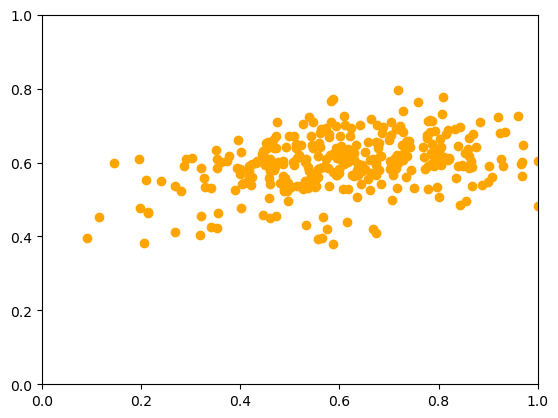

In [5]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

print(r2_score(conf_test, cov_pred_nn.flatten()))
print(pearsonr(conf_test, cov_pred_nn.flatten()))

plt.scatter(conf_test, cov_pred_nn, c="orange")
plt.xlim(0,1)
plt.ylim(0,1)